Aqui esta sendo realizdo uma EDA para a nossa ferramenta que vai predizer a localização de proteínas subcelulares 
--

In [2]:
##Data Colletion

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn


In [6]:
!wget -o membrane.fasta 'https://www.uniprot.org/uniprot/?query=taxonomy%3Abacteria+locations%3A(location%3Amembrane)&sort=score&format=fasta&limit=10000'

In [13]:
!wget -O cytoplasm.fasta 'https://www.uniprot.org/uniprot/?query=taxonomy%3Abacteria+locations%3A(location%3Acytoplasm)&sort=score&format=fasta&limit=10000'

--2021-04-29 19:16:00--  https://www.uniprot.org/uniprot/?query=taxonomy%3Abacteria+locations%3A(location%3Acytoplasm)&sort=score&format=fasta&limit=10000
Resolving www.uniprot.org (www.uniprot.org)... 193.62.193.81, 128.175.240.206
Connecting to www.uniprot.org (www.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘cytoplasm.fasta’

cytoplasm.fasta         [                <=> ]   5,78M   102KB/s    in 88s     

2021-04-29 19:17:34 (67,2 KB/s) - ‘cytoplasm.fasta’ saved [6062903]



In [3]:
from Bio import SeqIO


In [4]:
from Bio.SeqUtils import ProtParam

In [5]:
def compute_aa_composition(sequence):
    analyzer = ProtParam.ProteinAnalysis(str(sequence))
    return analyzer.get_amino_acids_percent()


In [6]:
df = pd.DataFrame()
handle = open('../data/raw/membrane.fasta')

parser = SeqIO.parse(handle, 'fasta')

for protein in parser:
    protein_data = compute_aa_composition(protein.seq)
    protein_data['membrane'] = 1
    df = df.append([protein_data], ignore_index = True)    

handle = open('cytoplasm.fasta')
parser = SeqIO.parse(handle, 'fasta')

for protein in parser:
    protein_data = compute_aa_composition(protein.seq)
    protein_data['membrane'] = 0
    df = df.append([protein_data], ignore_index=True)

# Exploratory Data Analasys

In [18]:
df_grouped = df.groupby(['membrane']).mean()
#df_grouped = round(df_grouped, 3)
df_grouped

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
membrane,,,,,,,,,,,,,,,,,,,,
0,0.099596,0.011595,0.056743,0.065825,0.026850,0.088984,0.026117,0.066100,0.054264,0.085344,0.020248,0.043467,0.038655,0.034842,0.052431,0.051365,0.060162,0.086719,0.005711,0.024890
1,0.105680,0.009934,0.057090,0.052834,0.040773,0.083558,0.024819,0.059536,0.038595,0.097306,0.028529,0.032032,0.049913,0.035478,0.054802,0.053191,0.054195,0.078225,0.016940,0.026497


Populating the interactive namespace from numpy and matplotlib


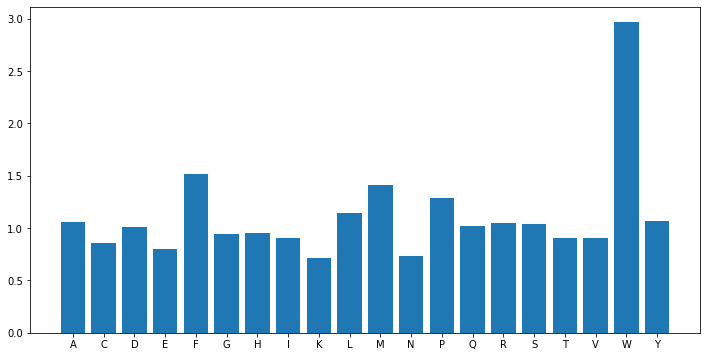

In [27]:
%pylab inline

pylab.rcParams['figure.figsize']=(12,6)
aminoacidos = df_grouped.columns


cytoplasm_mean_compostion = df_grouped.loc[0]
membrane_mean_composition = df_grouped.loc[1]

relative_difference = membrane_mean_composition/cytoplasm_mean_compostion
plt.bar(aminoacidos, relative_difference)
plt.show()




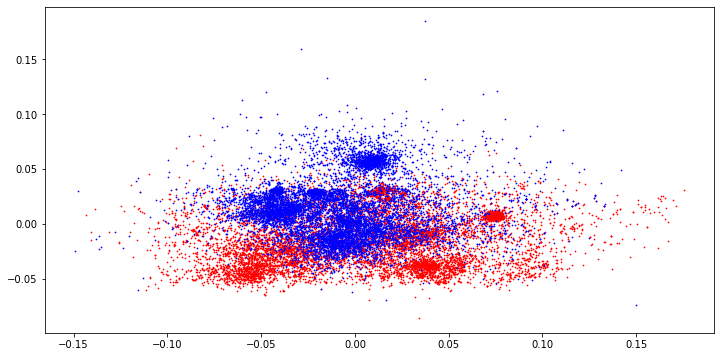

In [44]:
#redução de dimensionalidade. 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df.drop(['membrane'], axis=1))

for group, df_group in df.groupby('membrane'):
    components = pca.transform(df_group.drop('membrane', axis=1))
    plt.scatter(
        components[:,0],
        components[:,1],
        s = 0.52,
        label='Membrane' if group == 0 else 'Cytoplasm',
        color='red' if group == 0 else 'blue'
    )
plt.show()


In [45]:
#dividindo o dataset em dados de treino e dados de teste.

from sklearn.model_selection import train_test_split

X = df.drop(['membrane'], axis=1)
y = df['membrane']

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

# Model Validation


In [48]:
#Medidando a performance do algoritímo. 

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2545
           1       0.94      0.96      0.95      2455

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

